In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


In [2]:

df = pd.read_csv('dataset_sdn.csv')
df.head() 


,dt,switch,src,dst,pktcount,bytecount,dur,dur_nsec,tot_dur,flows,...,pktrate,Pairflow,Protocol,port_no,tx_bytes,rx_bytes,tx_kbps,rx_kbps,tot_kbps,label
0,11425,1,10.0.0.1,10.0.0.8,45304,48294064,100,716000000,1.010000e+11,3,...,451,0,UDP,3,143928631,3917,0,0.0,0.0,0
1,11605,1,10.0.0.1,10.0.0.8,126395,134737070,280,734000000,2.810000e+11,2,...,451,0,UDP,4,3842,3520,0,0.0,0.0,0
2,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,...,451,0,UDP,1,3795,1242,0,0.0,0.0,0
3,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,...,451,0,UDP,2,3688,1492,0,0.0,0.0,0
4,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,...,451,0,UDP,3,3413,3665,0,0.0,0.0,0


In [3]:

df.dropna(inplace=True)
df = pd.get_dummies(df, columns=['Protocol'], drop_first=True)
df.drop(columns=['src', 'dst'], inplace=True)
X = df.drop('label', axis=1)
y = df['label']


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [4]:

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [5]:

def custom_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)


In [6]:

class DDoSModel(nn.Module):
    def __init__(self):
        super(DDoSModel, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16, 1)
        self.dropout = nn.Dropout(0.5)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)
        self.layer_norm = nn.LayerNorm(128)
        self.shortcut = nn.Linear(X_train.shape[1], 32)  # Adjust dimensions for residual connection
    
    def forward(self, x):
        identity = x
        x = self.leaky_relu(self.layer_norm(self.fc1(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.fc2(x))
        x = self.dropout(x)
        x = self.leaky_relu(self.fc3(x))
        
        identity = self.shortcut(identity)  # Project to match the dimensions
        x += identity  # Residual connection

        x = self.leaky_relu(self.fc4(x))
        x = torch.sigmoid(self.fc5(x))
        return x


In [7]:

model = DDoSModel()
model.apply(custom_weights)


criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
epochs = 50


In [8]:

epoch_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()
        running_loss += loss.item()
    
    scheduler.step()
    avg_epoch_loss = running_loss / len(train_loader)
    epoch_losses.append(avg_epoch_loss)  # Record the average loss for this epoch
    print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_epoch_loss}')


Epoch 1/50, Loss: 0.1931776443631955
Epoch 2/50, Loss: 0.09923950277004485
Epoch 3/50, Loss: 0.07840262659355778
Epoch 4/50, Loss: 0.06419227799789128
Epoch 5/50, Loss: 0.05458553775848607
Epoch 6/50, Loss: 0.04792217075734063
Epoch 7/50, Loss: 0.04282583160040699
Epoch 8/50, Loss: 0.04014982428717501
Epoch 9/50, Loss: 0.034215634797403506
Epoch 10/50, Loss: 0.03605759739086761
Epoch 11/50, Loss: 0.023352123304735052
Epoch 12/50, Loss: 0.021657515670774338
Epoch 13/50, Loss: 0.021414816976748106
Epoch 14/50, Loss: 0.02104825274862971
Epoch 15/50, Loss: 0.020776424478867912
Epoch 16/50, Loss: 0.020552255785605385
Epoch 17/50, Loss: 0.019627246005378112
Epoch 18/50, Loss: 0.019577621796063826
Epoch 19/50, Loss: 0.019285394724141033
Epoch 20/50, Loss: 0.019259035441188344
Epoch 21/50, Loss: 0.018606364664989293
Epoch 22/50, Loss: 0.01864631971973348
Epoch 23/50, Loss: 0.018208732140263348
Epoch 24/50, Loss: 0.018710433792893364
Epoch 25/50, Loss: 0.01883949924636784
Epoch 26/50, Loss: 0.0

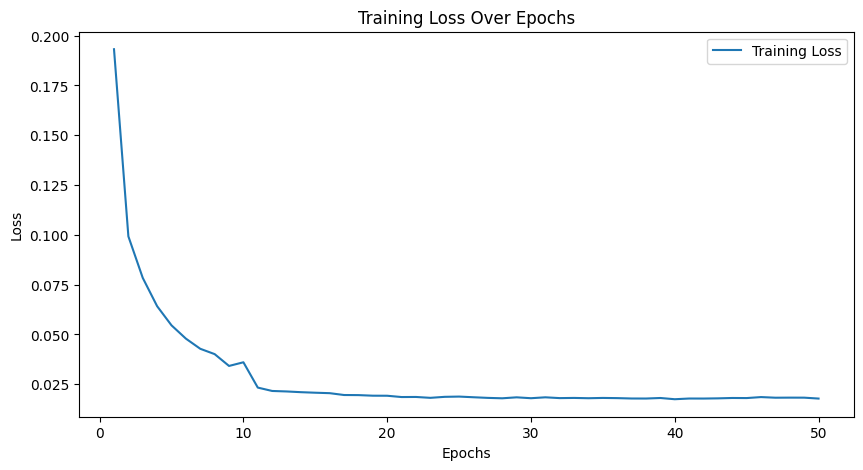

In [9]:

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), epoch_losses, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


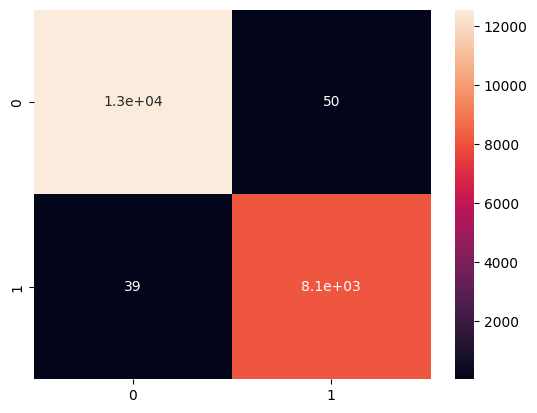

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12613
           1       0.99      1.00      0.99      8155

    accuracy                           1.00     20768
   macro avg       1.00      1.00      1.00     20768
weighted avg       1.00      1.00      1.00     20768



In [10]:

model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).round()
    
  
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True)
    plt.show()

  
    print(classification_report(y_test, y_pred))


In [11]:

with torch.no_grad():
    nn_preds = model(X_train_tensor).squeeze(1).detach().numpy()
    
gb = GradientBoostingClassifier(n_estimators=100)
gb.fit(nn_preds.reshape(-1, 1), y_train)
gb_preds = gb.predict(model(X_test_tensor).squeeze(1).detach().numpy().reshape(-1, 1))


print("Final Ensemble Model Evaluation:")
print(classification_report(y_test, gb_preds))


Final Ensemble Model Evaluation:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12613
           1       0.99      1.00      0.99      8155

    accuracy                           1.00     20768
   macro avg       0.99      1.00      0.99     20768
weighted avg       1.00      1.00      1.00     20768



In [12]:

gb_raw = GradientBoostingClassifier(n_estimators=100)
gb_raw.fit(X_train, y_train)


feature_importances = gb_raw.feature_importances_


importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)


print(importance_df)


         Feature  Importance
10   byteperflow    0.264043
9     pktperflow    0.235720
3      bytecount    0.213911
8      packetins    0.139777
2       pktcount    0.096347
19  Protocol_TCP    0.025239
11       pktrate    0.012505
6        tot_dur    0.005564
0             dt    0.003733
20  Protocol_UDP    0.001767
4            dur    0.001305
14      tx_bytes    0.000049
15      rx_bytes    0.000039
5       dur_nsec    0.000003
7          flows    0.000000
1         switch    0.000000
12      Pairflow    0.000000
13       port_no    0.000000
16       tx_kbps    0.000000
17       rx_kbps    0.000000
18      tot_kbps    0.000000


In [13]:
import warnings
warnings.filterwarnings('ignore')

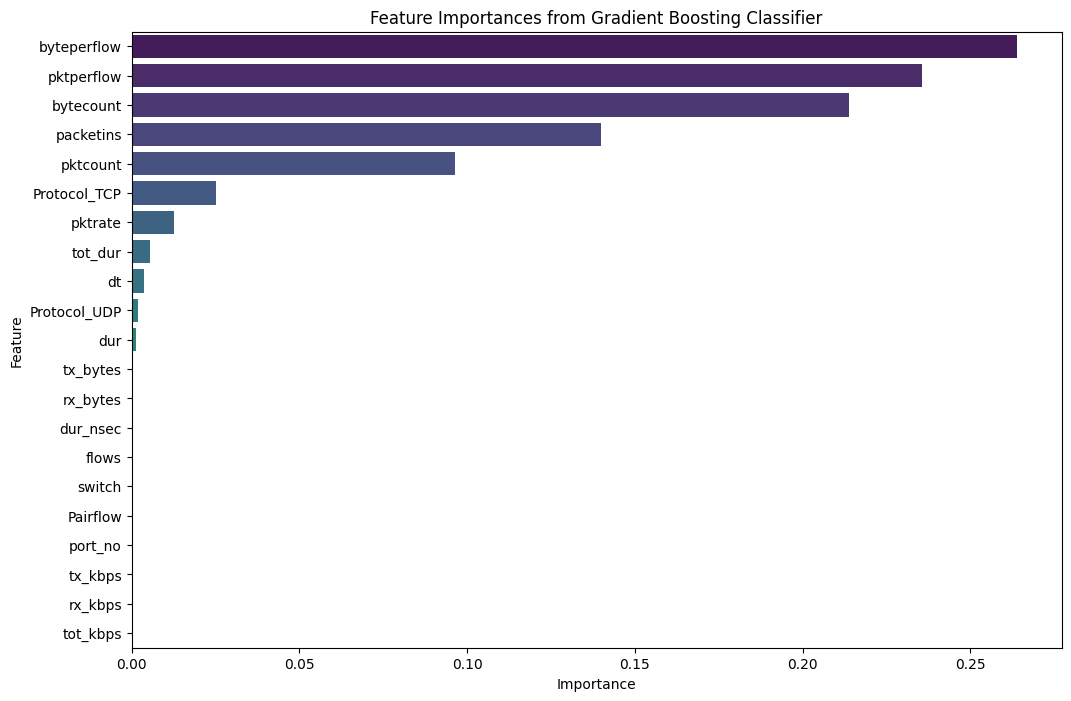

In [14]:

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importances from Gradient Boosting Classifier')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [15]:
import joblib


torch.save(model.state_dict(), 'ddos_model.pth')


joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']

In [16]:

column_names = df.columns.tolist()

print(column_names)


['dt', 'switch', 'pktcount', 'bytecount', 'dur', 'dur_nsec', 'tot_dur', 'flows', 'packetins', 'pktperflow', 'byteperflow', 'pktrate', 'Pairflow', 'port_no', 'tx_bytes', 'rx_bytes', 'tx_kbps', 'rx_kbps', 'tot_kbps', 'label', 'Protocol_TCP', 'Protocol_UDP']


In [17]:
import torch
import joblib
import numpy as np
import pandas as pd


model = DDoSModel()
model.load_state_dict(torch.load('ddos_model.pth'))
model.eval()


scaler = joblib.load('scaler.pkl')


In [18]:

input_data = np.array([[11335, 1, 4777, 5092282, 10, 711000000, 10711000000, 3, 1790, 0, 0, 0, 0, 1, 2, 3646, 1492, 0, 0, 0, 1]])


input_data_scaled = scaler.transform(input_data)


input_tensor = torch.tensor(input_data_scaled, dtype=torch.float32)


In [19]:

with torch.no_grad():
    prediction = model(input_tensor).round().item()

if prediction == 1:
    print("The input data indicates a DDoS attack.")
else:
    print("The input data does not indicate a DDoS attack.")


The input data indicates a DDoS attack.
